In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sep
import pandas as pd
import os
from astropy.table import Table, vstack

In [3]:
from maddeb.utils import listdir_fullpath, get_data_dir_path

In [4]:
logging.basicConfig(format="%(message)s", level=logging.INFO)
LOG = logging.getLogger(__name__)

In [5]:
import hickle as hkl
data_path = get_data_dir_path()
run_name = "catsim_high_density" # 12 to 20 galaxies

In [6]:
madness_results=[]
scarlet_results=[]

actual_photometry = []
madness_photometry = []
scarlet_photometry = []
blended_photometry = []

for file_num in range(19):
    madness_results.append(hkl.load(os.path.join(data_path, "results", run_name, "madness_reconstruction", str(file_num) + ".hkl")))
    scarlet_results.append(hkl.load(os.path.join(data_path, "results", run_name, "scarlet_reconstruction", str(file_num) + ".hkl")))
    
    actual_photometry.append(hkl.load(os.path.join(data_path, "results", run_name, "actual_photometry", str(file_num) + ".hkl")))
    madness_photometry.append(hkl.load(os.path.join(data_path, "results", run_name, "madness_photometry", str(file_num) + ".hkl")))
    scarlet_photometry.append(hkl.load(os.path.join(data_path, "results", run_name, "scarlet_photometry", str(file_num) + ".hkl")))
    blended_photometry.append(hkl.load(os.path.join(data_path, "results", run_name, "blended_photometry",  str(file_num) + ".hkl")))


        
madness_results = vstack(madness_results)
scarlet_results = vstack(scarlet_results)

actual_photometry = vstack(actual_photometry)
madness_photometry = vstack(madness_photometry)
scarlet_photometry = vstack(scarlet_photometry)
blended_photometry = vstack(blended_photometry)

In [7]:
for band_num, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    madness_results[band+"_relative_flux_err"] = (madness_results[band+"_predicted_flux"]-madness_results[band+"_actual_flux"])/madness_results[band+"_actual_flux"]
    scarlet_results[band+"_relative_flux_err"] = (scarlet_results[band+"_predicted_flux"]-scarlet_results[band+"_actual_flux"])/scarlet_results[band+"_actual_flux"]

In [8]:
scarlet_results

u_covariance,u_actual_flux,u_predicted_flux,u_blendedness,g_covariance,g_actual_flux,g_predicted_flux,g_blendedness,r_covariance,r_actual_flux,r_predicted_flux,r_blendedness,i_covariance,i_actual_flux,i_predicted_flux,i_blendedness,z_covariance,z_actual_flux,z_predicted_flux,z_blendedness,y_covariance,y_actual_flux,y_predicted_flux,y_blendedness,galaxy_num,size,field_num,file_num,galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab,r_band_snr,ref_mag,btk_size,x_peak,y_peak,not_drawn_u,not_drawn_g,not_drawn_r,not_drawn_i,not_drawn_z,not_drawn_y,u_relative_flux_err,g_relative_flux_err,r_relative_flux_err,i_relative_flux_err,z_relative_flux_err,y_relative_flux_err
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.9938072447919309,11093.922595011958,8158.19312519511,0.303697065061873,0.993531616781357,85021.96895730193,70872.2577335902,0.30942904947584116,0.9931669659189545,220440.3098899892,171064.60752829225,0.3041163737781841,0.9930345346700187,287068.5559277255,239599.75718044952,0.3169487650005054,0.9928907230677253,243722.83412646037,217732.05830728236,0.3106260403172465,0.9928279321117195,124430.57065487816,71330.92742399736,0.31338286430776985,0,2.934391691481652,0,0,402700974452,9.409833691169386,1.506851669501188,0.92939889431,1.52888593949e-19,1.87639304513e-17,0.0,0.103462003171,0.63225120306,0.0748507976532,0.374639600515,224.244827271,224.244827271,24.3499164581,24.3860778809,24.0959835052,23.4892063141,23.1251525879,23.0250339508,96.86181000637494,23.4892063141,2.934391691481652,149.04916848849678,109.53425835548337,0.0,0.0,0.0,0.0,0.0,0.0,-0.26462501830838525,-0.16642417715376265,-0.22398672178576554,-0.1653570123480437,-0.10664070895258086,-0.4267411372576478
0.9945363162384642,1038.079634132374,613.3037469709298,0.23493782382078232,0.9941796679855688,45992.64180281368,44510.599803333615,0.14833090971862417,0.9936731858819832,100291.50878050516,92248.59584305383,0.24971854827626394,0.9934751595736918,70732.19344504422,63186.04042408127,0.32667775658084786,0.9932553422523196,41315.85852278577,52248.344436798536,0.3745161467531869,0.9931550703515056,18251.019527916535,22554.819639210436,0.41505920508180816,1,3.20668812036312,0,0,402703695649,-12.527761683560753,6.669819321593877,3.22528791428,0.0,1.97217807852e-18,0.0,0.0,0.688130497932,0.0,0.623354494572,0.0,341.729522705,26.9207649231,25.0528125763,24.9506931305,25.0097541809,25.0517215729,25.1087379456,44.60263238955758,25.0097541809,3.20668812036312,39.361191505225015,135.3490966810131,0.0,0.0,0.0,0.0,0.0,0.0,-0.4091939319438354,-0.032223458827046594,-0.080195352879313,-0.1066862577480504,0.26460749709420855,0.23581149013132457
0.9845744802334742,8729.682888733558,8822.948376559363,0.10262486932386838,0.9840109773020853,66660.47891558573,71674.48353278093,0.1278501487359217,0.9832523145259005,128902.10820024891,135857.00792016953,0.16622775072137186,0.9829658592803416,103480.37987850665,122301.17782111093,0.2097125784417716,0.9826605323135684,74685.33180605865,90401.54840190124,0.18490444160661434,0.9825248045065648,43824.85408061743,40602.052461423926,0.1584487559035085,2,2.9987727965302757,0,0,402702291885,-1.8515985808973578,1.5825724618448795,1.6642203331,1.95283900939e-19,7.89798335438e-18,0.0,0.141510695219,0.651383280754,0.139605402946,0.627531170845,140.861190796,140.861190796,24.6102561951,24.6504096985,24.6787395477,24.5972042084,24.4094905853,24.1582489014,57.137388551787396,24.5972042084,2.9987727965302757,92.74200709518443,10

In [9]:
actual_photometry

u_flux,u_fluxerrs,u_flags,g_flux,g_fluxerrs,g_flags,r_flux,r_fluxerrs,r_flags,i_flux,i_fluxerrs,i_flags,z_flux,z_fluxerrs,z_flags,y_flux,y_fluxerrs,y_flags,galaxy_num,field_num,file_num
float64,float64,int16,float64,float64,int16,float64,float64,int16,float64,float64,int16,float64,float64,int16,float64,float64,int16,int64,int64,int64
7309.5213993787775,345.17612408123216,0,56875.348337860116,1382.9645428559893,0,146654.11412475575,3176.268963294435,0,192466.87623168944,3825.481639120753,0,170671.8348310852,4437.744408550926,0,85843.54017814634,4791.174840527113,0,0,0,0
621.2940153813363,345.26403344827094,0,25972.090056915287,1383.316755912217,0,57085.56606224063,3177.0778946620117,0,42237.95585908889,3826.4559118066422,0,39229.372160429964,4438.874612162413,0,21276.59147804261,4792.395055710663,0,1,0,0
4615.927915043831,345.52762735365815,0,37529.53548706531,1384.3728574193353,0,73655.79853866577,3179.5034539118687,0,64814.107682189926,3829.377242614,0,45225.02300811767,4442.2634977143125,0,21472.591923599244,4796.053838573958,0,2,0,0
3367.254542484284,345.35192043797196,0,25655.74162355423,1383.668879312578,0,63129.648084316264,3177.8866201160336,0,87233.26139556883,3827.4299364913263,0,75517.79927951812,4440.004528080461,0,39452.975915444804,4793.614960288321,0,3,0,0
26365.797600708014,345.96650423239134,0,216411.75034545898,1386.1312384880807,0,497042.84299804684,3183.5419458914002,0,498890.5634814454,3834.241181120458,0,338639.0542797851,4447.905902500636,0,162265.0917353821,4802.145615243253,0,4,0,0
3983.07688615799,345.6154473137377,0,41614.40073898315,1384.7247122623328,0,165597.89210083004,3180.3115625674163,0,140412.35618011473,3830.3505244298467,0,94911.65170516964,4443.392551868448,0,50075.18214099884,4797.272812755181,0,5,0,0
53381.631005401636,345.26403344827094,0,399428.7715893555,1383.316755912217,0,1176084.6460742182,3177.077894662012,0,1021905.1429150389,3826.4559118066427,0,835750.4964331057,4438.874612162412,0,493601.16875000007,4792.395055710662,0,6,0,0
3632.624891734123,346.0542128164427,0,19108.77197216272,1386.4826470977287,0,79620.58630677222,3184.349029678201,0,99551.25011455535,3835.2132285897746,0,103069.44882553098,4449.0335247528765,0,76731.06645777702,4803.36304348318,0,7,0,0
-174.97280866742133,345.17612408123216,0,13331.805574359892,1382.9645428559893,0,130465.33573036194,3176.2689632944343,0,206726.4829394531,3825.481639120753,0,175019.57495950704,4437.744408550924,0,97206.38872293472,4791.174840527112,0,8,0,0


### Plot the correlations

(0.98, 1.0)

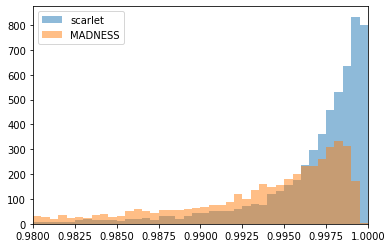

In [10]:
bins = np.arange(0.95, 1, 0.0005)
cov_band = 'u'
plt.hist(scarlet_results[cov_band + '_covariance'], bins=bins, alpha=0.5, label="scarlet")
plt.hist(madness_results[cov_band + '_covariance'], bins=bins, alpha=0.5, label="MADNESS")
plt.legend()
plt.xlim([0.98, 1])

### Plot the relative flux error

In [11]:
def gauss(x, sig, mu, a):
    return np.exp(-(x-mu)**2/(2*sig**2))/(np.sqrt(2*np.pi)*sig)

In [12]:
from scipy.optimize import curve_fit
from scipy.stats import norm

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
Madness mu: 0.11054397403440279
Madness sig: 0.45699618597782954
Scarlet mu: 0.062193132016991004
Scarlet sig: 0.4296454481950994


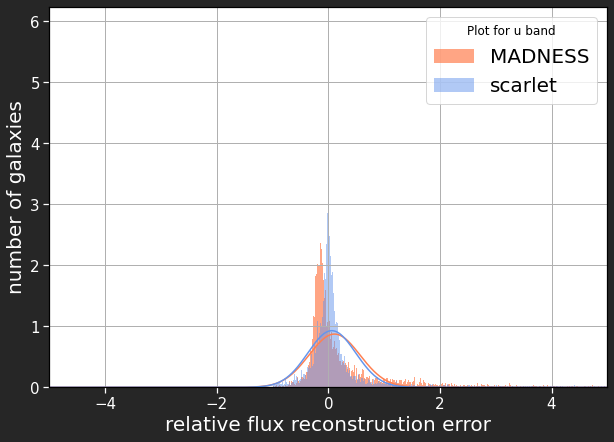

Madness mu: -0.07394431820074675
Madness sig: 0.2412498427835949
Scarlet mu: -0.0332362079254181
Scarlet sig: 0.24397510750748483


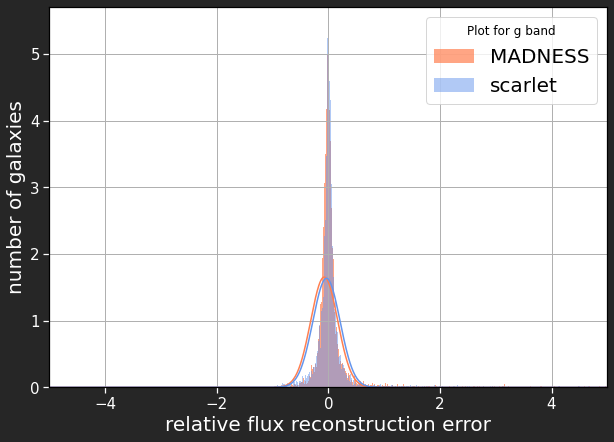

Madness mu: -0.012526445675468472
Madness sig: 0.12746932560077753
Scarlet mu: 0.056593934735179444
Scarlet sig: 0.1966733780304892


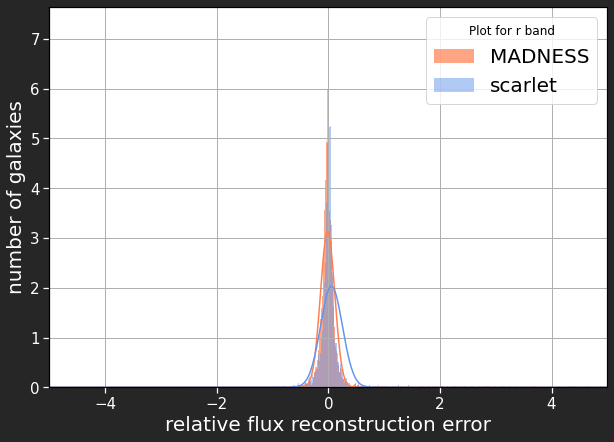

Madness mu: -0.017231990307567422
Madness sig: 0.10706163941501136
Scarlet mu: -0.0027891700594195384
Scarlet sig: 0.11798561263883975


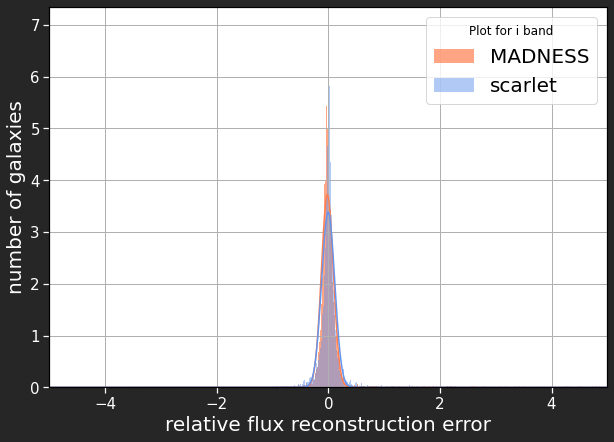

Madness mu: -0.007075713944183698
Madness sig: 0.127791530260059
Scarlet mu: 0.002679362109748912
Scarlet sig: 0.10015198322108791


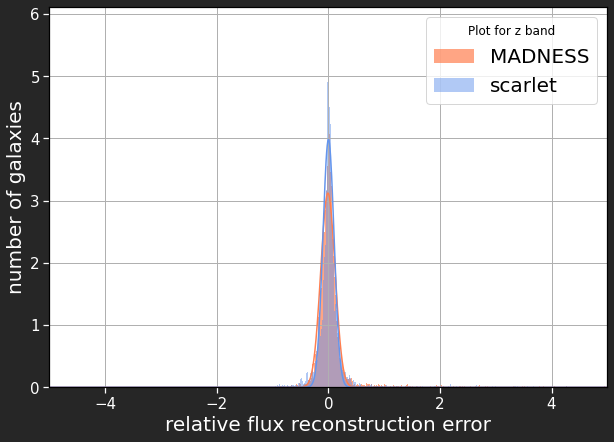

Madness mu: 0.013465967833941127
Madness sig: 0.20566481715289422
Scarlet mu: 0.003609145242837348
Scarlet sig: 0.13971471446411632


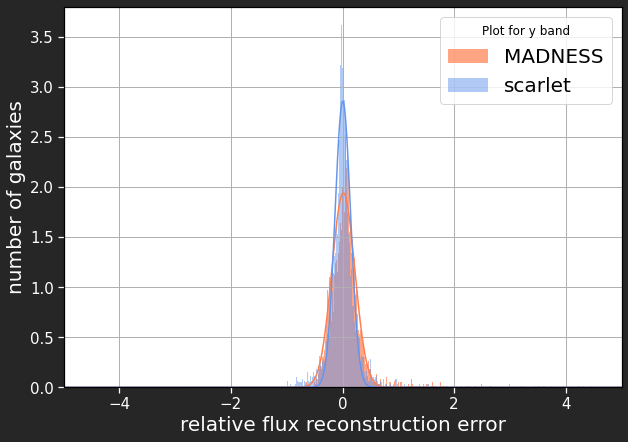

In [13]:
for band_number, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):

    madness_actual_flux = madness_results[band+"_actual_flux"].value
    madness_predicted_flux = madness_results[band+"_predicted_flux"].value

    scarlet_actual_flux = scarlet_results[band+"_actual_flux"].value
    scarlet_predicted_flux = scarlet_results[band+"_predicted_flux"].value

    scarlet_relative_difference = np.divide(
        scarlet_predicted_flux - scarlet_actual_flux, scarlet_actual_flux
    )
    madness_relative_difference = np.divide(
        madness_predicted_flux - madness_actual_flux, madness_actual_flux
    )
    
    n_bins = 1000

    hist, bin_tmp = np.histogram(madness_relative_difference, n_bins, density=True)
    bins = np.mean((bin_tmp[:-1], bin_tmp[1:]), 0)
    madness_fit = curve_fit(gauss, bins, hist, p0=[np.std(bins), np.mean(bins), 10])

    hist, bin_tmp = np.histogram(scarlet_relative_difference, n_bins, density=True)
    bins = np.mean((bin_tmp[:-1], bin_tmp[1:]), 0)
    scarlet_fit = curve_fit(gauss, bins, hist, p0=[np.std(bins), np.mean(bins), 10])
    
    sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'black',
                     'image.cmap': 'viridis',})
    plt.figure(figsize=(10, 7))
    bins = np.arange(-5, 5, 0.01)
    plt.hist(
        madness_relative_difference[
            np.logical_not(np.isnan(madness_relative_difference))
        ].reshape(-1),
        bins=bins,
        density=True,
        alpha=0.7,
        color="coral",
        label="MADNESS",
    )
    plt.plot(bins, gauss(bins, *madness_fit[0]), color="coral")
    LOG.info("Madness mu: " + str(madness_fit[0][1]))
    LOG.info("Madness sig: " + str(madness_fit[0][0]))
    plt.hist(
        scarlet_relative_difference[
            np.logical_not(np.isnan(scarlet_relative_difference))
        ].reshape(-1),
        bins=bins,
        density=True,
        alpha=0.5,
        color="cornflowerblue",
        label="scarlet",
    )
    plt.plot(
        bins, gauss(bins, scarlet_fit[0][0], scarlet_fit[0][1], scarlet_fit[0][2]), color="cornflowerblue"
    )
    LOG.info("Scarlet mu: " + str(scarlet_fit[0][1]))
    LOG.info("Scarlet sig: " + str(scarlet_fit[0][0]))
    plt.legend(fontsize=20, title = "Plot for " + band + " band")
    ax = plt.gca()
    plt.xlabel("relative flux reconstruction error", fontsize=20)
    ax.tick_params(labelsize=15)
    plt.ylabel("number of galaxies", fontsize=20)
    plt.xlim([-5, 5])
    plt.show()

Madness mu: 0.11054397403440279
Madness sig: 0.45699618597782954
Scarlet mu: 0.062193132016991004
Scarlet sig: 0.4296454481950994


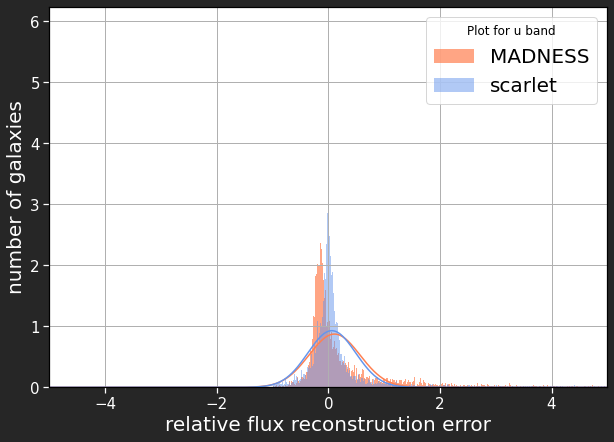

Madness mu: -0.07394431820074675
Madness sig: 0.2412498427835949
Scarlet mu: -0.0332362079254181
Scarlet sig: 0.24397510750748483


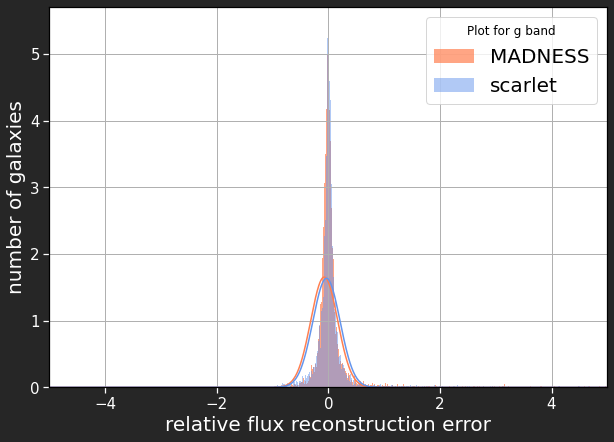

Madness mu: -0.012526445675468472
Madness sig: 0.12746932560077753
Scarlet mu: 0.056593934735179444
Scarlet sig: 0.1966733780304892


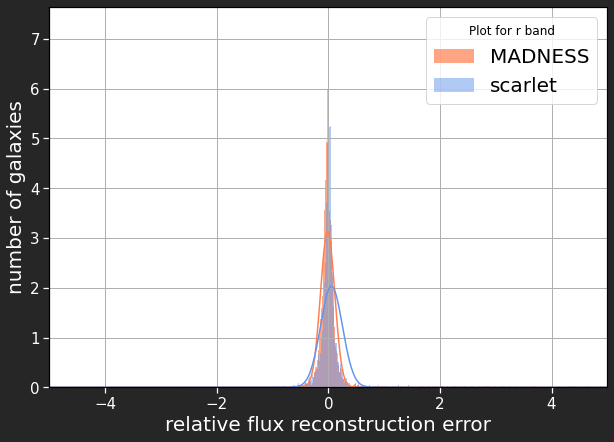

Madness mu: -0.017231990307567422
Madness sig: 0.10706163941501136
Scarlet mu: -0.0027891700594195384
Scarlet sig: 0.11798561263883975


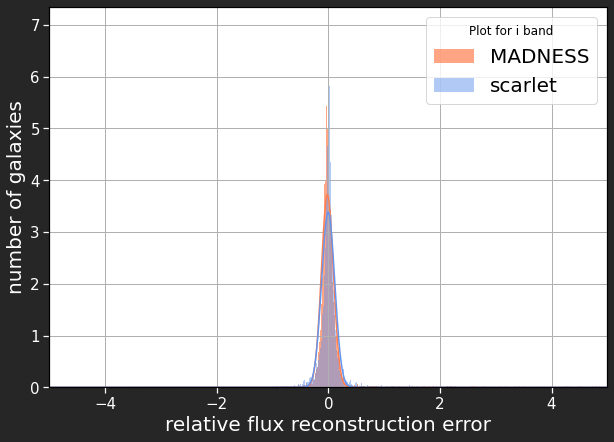

Madness mu: -0.007075713944183698
Madness sig: 0.127791530260059
Scarlet mu: 0.002679362109748912
Scarlet sig: 0.10015198322108791


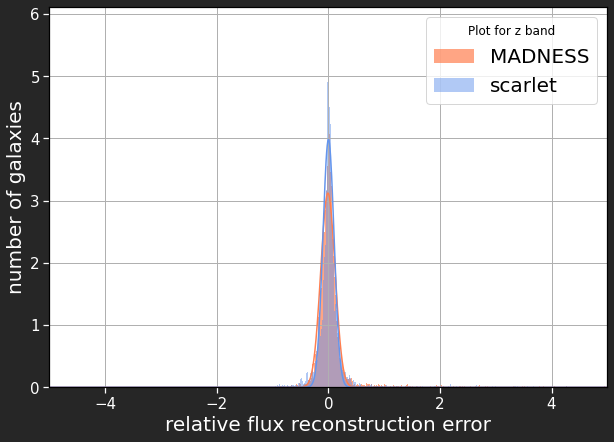

Madness mu: 0.013465967833941127
Madness sig: 0.20566481715289422
Scarlet mu: 0.003609145242837348
Scarlet sig: 0.13971471446411632


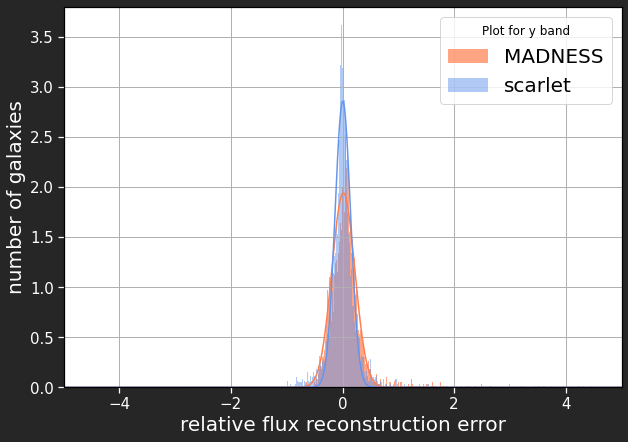

In [14]:
for band_number, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):

    madness_actual_flux = madness_results[band+"_actual_flux"].value
    madness_predicted_flux = madness_results[band+"_predicted_flux"].value

    scarlet_actual_flux = scarlet_results[band+"_actual_flux"].value
    scarlet_predicted_flux = scarlet_results[band+"_predicted_flux"].value

    scarlet_relative_difference = np.divide(
        scarlet_predicted_flux - scarlet_actual_flux, scarlet_actual_flux
    )
    madness_relative_difference = np.divide(
        madness_predicted_flux - madness_actual_flux, madness_actual_flux
    )
    
    n_bins = 1000

    hist, bin_tmp = np.histogram(madness_relative_difference, n_bins, density=True)
    bins = np.mean((bin_tmp[:-1], bin_tmp[1:]), 0)
    madness_fit = curve_fit(gauss, bins, hist, p0=[np.std(bins), np.mean(bins), 10])

    hist, bin_tmp = np.histogram(scarlet_relative_difference, n_bins, density=True)
    bins = np.mean((bin_tmp[:-1], bin_tmp[1:]), 0)
    scarlet_fit = curve_fit(gauss, bins, hist, p0=[np.std(bins), np.mean(bins), 10])
    
    sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'black',
                     'image.cmap': 'viridis',})
    plt.figure(figsize=(10, 7))
    bins = np.arange(-5, 5, 0.01)
    plt.hist(
        madness_relative_difference[
            np.logical_not(np.isnan(madness_relative_difference))
        ].reshape(-1),
        bins=bins,
        density=True,
        alpha=0.7,
        color="coral",
        label="MADNESS",
    )
    plt.plot(bins, gauss(bins, *madness_fit[0]), color="coral")
    LOG.info("Madness mu: " + str(madness_fit[0][1]))
    LOG.info("Madness sig: " + str(madness_fit[0][0]))
    plt.hist(
        scarlet_relative_difference[
            np.logical_not(np.isnan(scarlet_relative_difference))
        ].reshape(-1),
        bins=bins,
        density=True,
        alpha=0.5,
        color="cornflowerblue",
        label="scarlet",
    )
    plt.plot(
        bins, gauss(bins, scarlet_fit[0][0], scarlet_fit[0][1], scarlet_fit[0][2]), color="cornflowerblue"
    )
    LOG.info("Scarlet mu: " + str(scarlet_fit[0][1]))
    LOG.info("Scarlet sig: " + str(scarlet_fit[0][0]))
    plt.legend(fontsize=20, title = "Plot for " + band + " band")
    ax = plt.gca()
    plt.xlabel("relative flux reconstruction error", fontsize=20)
    ax.tick_params(labelsize=15)
    plt.ylabel("number of galaxies", fontsize=20)
    plt.xlim([-5, 5])
    plt.show()

# Compare apperture photometry

In [15]:
actual_photometry

u_flux,u_fluxerrs,u_flags,g_flux,g_fluxerrs,g_flags,r_flux,r_fluxerrs,r_flags,i_flux,i_fluxerrs,i_flags,z_flux,z_fluxerrs,z_flags,y_flux,y_fluxerrs,y_flags,galaxy_num,field_num,file_num
float64,float64,int16,float64,float64,int16,float64,float64,int16,float64,float64,int16,float64,float64,int16,float64,float64,int16,int64,int64,int64
7309.5213993787775,345.17612408123216,0,56875.348337860116,1382.9645428559893,0,146654.11412475575,3176.268963294435,0,192466.87623168944,3825.481639120753,0,170671.8348310852,4437.744408550926,0,85843.54017814634,4791.174840527113,0,0,0,0
621.2940153813363,345.26403344827094,0,25972.090056915287,1383.316755912217,0,57085.56606224063,3177.0778946620117,0,42237.95585908889,3826.4559118066422,0,39229.372160429964,4438.874612162413,0,21276.59147804261,4792.395055710663,0,1,0,0
4615.927915043831,345.52762735365815,0,37529.53548706531,1384.3728574193353,0,73655.79853866577,3179.5034539118687,0,64814.107682189926,3829.377242614,0,45225.02300811767,4442.2634977143125,0,21472.591923599244,4796.053838573958,0,2,0,0
3367.254542484284,345.35192043797196,0,25655.74162355423,1383.668879312578,0,63129.648084316264,3177.8866201160336,0,87233.26139556883,3827.4299364913263,0,75517.79927951812,4440.004528080461,0,39452.975915444804,4793.614960288321,0,3,0,0
26365.797600708014,345.96650423239134,0,216411.75034545898,1386.1312384880807,0,497042.84299804684,3183.5419458914002,0,498890.5634814454,3834.241181120458,0,338639.0542797851,4447.905902500636,0,162265.0917353821,4802.145615243253,0,4,0,0
3983.07688615799,345.6154473137377,0,41614.40073898315,1384.7247122623328,0,165597.89210083004,3180.3115625674163,0,140412.35618011473,3830.3505244298467,0,94911.65170516964,4443.392551868448,0,50075.18214099884,4797.272812755181,0,5,0,0
53381.631005401636,345.26403344827094,0,399428.7715893555,1383.316755912217,0,1176084.6460742182,3177.077894662012,0,1021905.1429150389,3826.4559118066427,0,835750.4964331057,4438.874612162412,0,493601.16875000007,4792.395055710662,0,6,0,0
3632.624891734123,346.0542128164427,0,19108.77197216272,1386.4826470977287,0,79620.58630677222,3184.349029678201,0,99551.25011455535,3835.2132285897746,0,103069.44882553098,4449.0335247528765,0,76731.06645777702,4803.36304348318,0,7,0,0
-174.97280866742133,345.17612408123216,0,13331.805574359892,1382.9645428559893,0,130465.33573036194,3176.2689632944343,0,206726.4829394531,3825.481639120753,0,175019.57495950704,4437.744408550924,0,97206.38872293472,4791.174840527112,0,8,0,0


In [16]:
madness_photometry

u_flux,u_fluxerrs,u_flags,g_flux,g_fluxerrs,g_flags,r_flux,r_fluxerrs,r_flags,i_flux,i_fluxerrs,i_flags,z_flux,z_fluxerrs,z_flags,y_flux,y_fluxerrs,y_flags,galaxy_num,field_num,file_num
float64,float64,int16,float64,float64,int16,float64,float64,int16,float64,float64,int16,float64,float64,int16,float64,float64,int16,int64,int64,int64
9382.93024658978,345.17612408123216,0,70922.45960700986,1382.9645428559893,0,150811.43889465337,3176.268963294435,0,173070.5592712402,3825.481639120753,0,135653.8873023987,4437.744408550926,0,56325.02069431305,4791.174840527113,0,0,0,0
516.7798398661612,345.26403344827094,0,25450.158712539676,1383.316755912217,0,56056.986457748426,3177.0778946620117,0,40101.87769008636,3826.4559118066422,0,37224.54088996888,4438.874612162413,0,19914.649226561793,4792.395055710663,0,1,0,0
4603.480701891182,345.52762735365815,0,37517.14795738221,1384.3728574193353,0,73936.99984115598,3179.5034539118687,0,65852.84784296036,3829.377242614,0,44864.05717396737,4442.2634977143125,0,20849.702468109135,4796.053838573958,0,2,0,0
2096.3364217141275,345.35192043797196,0,11363.308666068911,1383.668879312578,0,49064.52494884491,3177.8866201160336,0,121502.50389244074,3827.4299364913263,0,112862.95598419188,4440.004528080461,0,49237.84050536156,4793.614960288321,0,3,0,0
26378.36212677002,345.96650423239134,0,216540.6067883301,1386.1312384880807,0,497411.44562011724,3183.5419458914002,0,499292.08667968755,3834.241181120458,0,338898.5012841797,4447.905902500636,0,162395.0872290039,4802.145615243253,0,4,0,0
3912.496849784851,345.6154473137377,0,40939.23179382324,1384.7247122623328,0,164039.9802166748,3180.3115625674163,0,138979.25552673335,3830.3505244298467,0,93774.67888744354,4443.392551868448,0,49315.574029121395,4797.272812755181,0,5,0,0
53382.69873046876,345.26403344827094,0,399439.6701196291,1383.316755912217,0,1176115.9860595707,3177.077894662012,0,1021939.6349414064,3826.4559118066427,0,835774.7895629884,4438.874612162412,0,493613.9976241302,4792.395055710662,0,6,0,0
3640.2082120823866,346.0542128164427,0,19230.01427516938,1386.4826470977287,0,80611.29131587983,3184.349029678201,0,100831.78103157044,3835.2132285897746,0,103650.2940611267,4449.0335247528765,0,76963.08194545744,4803.36304348318,0,7,0,0
-173.19361879825595,345.17612408123216,0,13350.158601989746,1382.9645428559893,0,130527.0150339508,3176.2689632944343,0,206791.3349682617,3825.481639120753,0,175066.14550540925,4437.744408550924,0,97231.9073810387,4791.174840527112,0,8,0,0


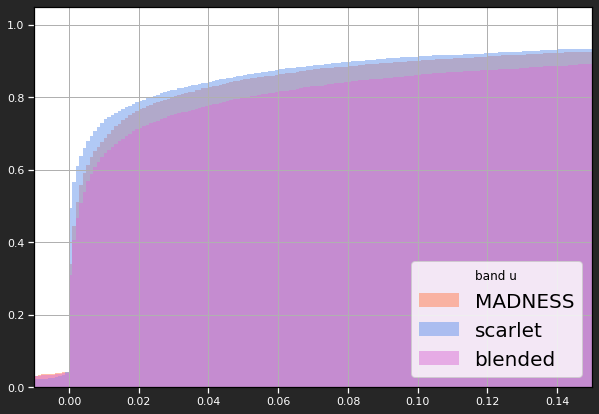

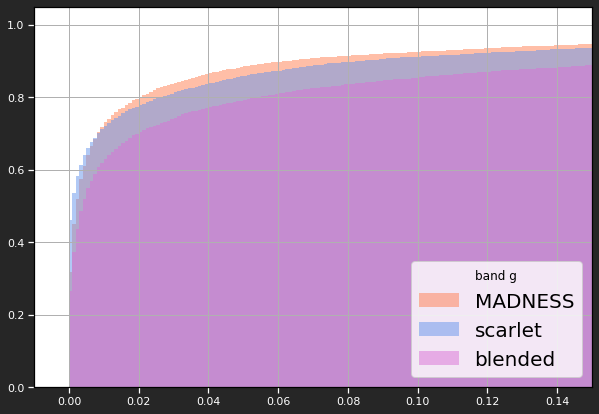

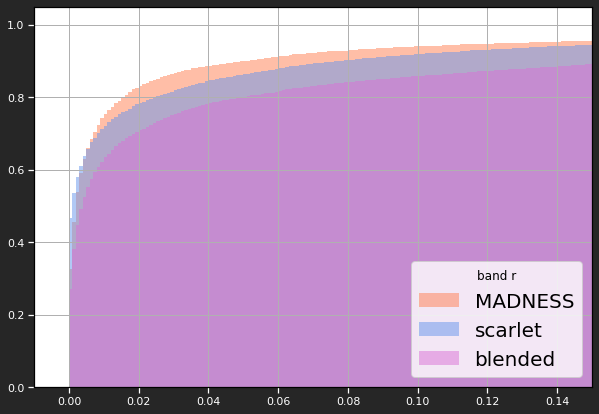

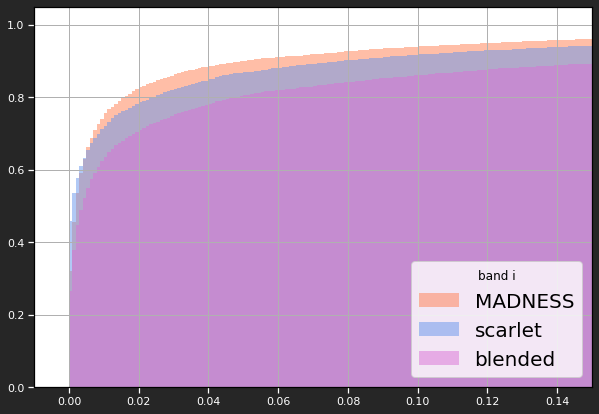

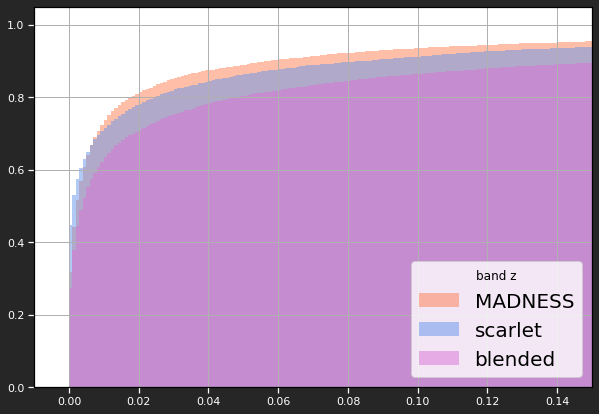

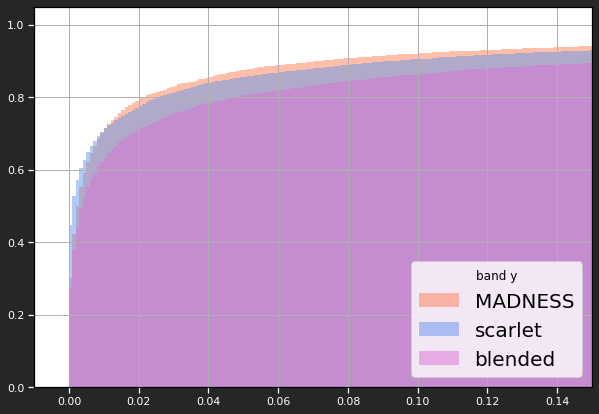

In [17]:
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    plt.figure(figsize=(10, 7))
    bins = np.arange(-1, 1, 0.001)
    plt.hist(
        np.abs((madness_photometry[band+"_flux"].value - actual_photometry[band+"_flux"].value)) / actual_photometry[band+"_flux"].value,
        bins=bins,
        alpha=0.5,
        density=True,
        label="MADNESS",
        cumulative=True,
        color="coral"
    )

    plt.hist(
        np.abs((scarlet_photometry[band+"_flux"].value - actual_photometry[band+"_flux"].value)) / actual_photometry[band+"_flux"].value,
        bins=bins,
        density=True,
        alpha=0.5,
        label="scarlet",
        cumulative=True,
        color="cornflowerblue"
    )

    plt.hist(
        (blended_photometry[band+"_flux"].value - actual_photometry[band+"_flux"].value) / actual_photometry[band+"_flux"].value,
        bins=bins,
        alpha=0.5,
        density=True,
        label="blended",
        cumulative=True,
        color="orchid",
    )
    plt.xlim([-.01, .15])

    plt.legend(fontsize=20, title="band " + band, loc="lower right")
    plt.show()

# error variation plots

/tmp/ipykernel_15404/4022407744.py:1: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  h = plt.hist2d(madness_results['size'].value, madness_results["r_relative_flux_err"], range=[[0, 1], [-.4,.4]], bins=30, cmin=2)
/tmp/ipykernel_15404/4022407744.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(h[3])


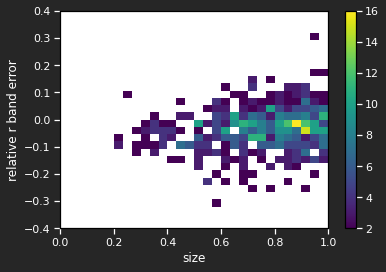

In [18]:
h = plt.hist2d(madness_results['size'].value, madness_results["r_relative_flux_err"], range=[[0, 1], [-.4,.4]], bins=30, cmin=2)
plt.xlabel("size")
plt.ylabel("relative r band error")
plt.colorbar(h[3])
#plt.ylim(-.1,.1)

# Plot SNR

In [19]:
madness_results

u_covariance,u_actual_flux,u_predicted_flux,u_blendedness,g_covariance,g_actual_flux,g_predicted_flux,g_blendedness,r_covariance,r_actual_flux,r_predicted_flux,r_blendedness,i_covariance,i_actual_flux,i_predicted_flux,i_blendedness,z_covariance,z_actual_flux,z_predicted_flux,z_blendedness,y_covariance,y_actual_flux,y_predicted_flux,y_blendedness,galaxy_num,size,field_num,file_num,galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab,r_band_snr,ref_mag,btk_size,x_peak,y_peak,not_drawn_u,not_drawn_g,not_drawn_r,not_drawn_i,not_drawn_z,not_drawn_y,u_relative_flux_err,g_relative_flux_err,r_relative_flux_err,i_relative_flux_err,z_relative_flux_err,y_relative_flux_err
float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,int64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.9972354174684143,11093.922595011958,12114.163,0.303697065061873,0.9976326172700148,85021.96895730193,99982.07,0.30942904947584116,0.9979606588965744,220440.3098899892,228170.69,0.3041163737781841,0.998174890812118,287068.5559277255,222102.23,0.3169487650005054,0.9982081709319021,243722.83412646037,176078.9,0.3106260403172465,0.9973209903913982,124430.57065487816,102329.445,0.31338286430776985,0,2.934391691481652,0,0,402700974452,9.409833691169386,1.506851669501188,0.92939889431,1.52888593949e-19,1.87639304513e-17,0.0,0.103462003171,0.63225120306,0.0748507976532,0.374639600515,224.244827271,224.244827271,24.3499164581,24.3860778809,24.0959835052,23.4892063141,23.1251525879,23.0250339508,96.86181000637494,23.4892063141,2.934391691481652,149.04916848849678,109.53425835548337,0.0,0.0,0.0,0.0,0.0,0.0,0.09196390926544429,0.17595571519534017,0.03506789485946849,-0.22630943100951087,-0.2775444825221505,-0.17761813054508974
0.993154206139304,1038.079634132374,4090.4248,0.23493782382078232,0.9973498327217554,45992.64180281368,38786.535,0.14833090971862417,0.996748374238049,100291.50878050516,83842.19,0.24971854827626394,0.9950164791397603,70732.19344504422,70039.89,0.32667775658084786,0.9938667928850274,41315.85852278577,49840.723,0.3745161467531869,0.9899808016884669,18251.019527916535,27857.816,0.41505920508180816,1,3.20668812036312,0,0,402703695649,-12.527761683560753,6.669819321593877,3.22528791428,0.0,1.97217807852e-18,0.0,0.0,0.688130497932,0.0,0.623354494572,0.0,341.729522705,26.9207649231,25.0528125763,24.9506931305,25.0097541809,25.0517215729,25.1087379456,44.60263238955758,25.0097541809,3.20668812036312,39.361191505225015,135.3490966810131,0.0,0.0,0.0,0.0,0.0,0.0,2.9403767015487916,-0.15667955490486385,-0.16401509440351153,-0.009787662255689965,0.20633394629238438,0.5263704235064254
0.997020131573681,8729.682888733558,7471.495,0.10262486932386838,0.9969793811989276,66660.47891558573,69728.53,0.1278501487359217,0.9974776936867431,128902.10820024891,136490.22,0.16622775072137186,0.9973467344660806,103480.37987850665,108434.875,0.2097125784417716,0.9965781481333429,74685.33180605865,77414.67,0.18490444160661434,0.9925178924348107,43824.85408061743,42425.004,0.1584487559035085,2,2.9987727965302757,0,0,402702291885,-1.8515985808973578,1.5825724618448795,1.6642203331,1.95283900939e-19,7.89798335438e-18,0.0,0.141510695219,0.651383280754,0.139605402946,0.627531170845,140.861190796,140.861190796,24.6102561951,24.6504096985,24.6787395477,24.5972042084,24.4094905853,24.1582489014,57.137388551787396,24.5972042084,2.9987727965302757,92.74200709518443,109.91286230985672,0.0,0.0,0.0,0.0,0.0,0.0,-0.14412754593524382,0.0460250568901469,0.0588672338699301,0.047878594254391844,0.036544526253546664,-0.031941924365392

In [20]:
madness_photometry

u_flux,u_fluxerrs,u_flags,g_flux,g_fluxerrs,g_flags,r_flux,r_fluxerrs,r_flags,i_flux,i_fluxerrs,i_flags,z_flux,z_fluxerrs,z_flags,y_flux,y_fluxerrs,y_flags,galaxy_num,field_num,file_num
float64,float64,int16,float64,float64,int16,float64,float64,int16,float64,float64,int16,float64,float64,int16,float64,float64,int16,int64,int64,int64
9382.93024658978,345.17612408123216,0,70922.45960700986,1382.9645428559893,0,150811.43889465337,3176.268963294435,0,173070.5592712402,3825.481639120753,0,135653.8873023987,4437.744408550926,0,56325.02069431305,4791.174840527113,0,0,0,0
516.7798398661612,345.26403344827094,0,25450.158712539676,1383.316755912217,0,56056.986457748426,3177.0778946620117,0,40101.87769008636,3826.4559118066422,0,37224.54088996888,4438.874612162413,0,19914.649226561793,4792.395055710663,0,1,0,0
4603.480701891182,345.52762735365815,0,37517.14795738221,1384.3728574193353,0,73936.99984115598,3179.5034539118687,0,65852.84784296036,3829.377242614,0,44864.05717396737,4442.2634977143125,0,20849.702468109135,4796.053838573958,0,2,0,0
2096.3364217141275,345.35192043797196,0,11363.308666068911,1383.668879312578,0,49064.52494884491,3177.8866201160336,0,121502.50389244074,3827.4299364913263,0,112862.95598419188,4440.004528080461,0,49237.84050536156,4793.614960288321,0,3,0,0
26378.36212677002,345.96650423239134,0,216540.6067883301,1386.1312384880807,0,497411.44562011724,3183.5419458914002,0,499292.08667968755,3834.241181120458,0,338898.5012841797,4447.905902500636,0,162395.0872290039,4802.145615243253,0,4,0,0
3912.496849784851,345.6154473137377,0,40939.23179382324,1384.7247122623328,0,164039.9802166748,3180.3115625674163,0,138979.25552673335,3830.3505244298467,0,93774.67888744354,4443.392551868448,0,49315.574029121395,4797.272812755181,0,5,0,0
53382.69873046876,345.26403344827094,0,399439.6701196291,1383.316755912217,0,1176115.9860595707,3177.077894662012,0,1021939.6349414064,3826.4559118066427,0,835774.7895629884,4438.874612162412,0,493613.9976241302,4792.395055710662,0,6,0,0
3640.2082120823866,346.0542128164427,0,19230.01427516938,1386.4826470977287,0,80611.29131587983,3184.349029678201,0,100831.78103157044,3835.2132285897746,0,103650.2940611267,4449.0335247528765,0,76963.08194545744,4803.36304348318,0,7,0,0
-173.19361879825595,345.17612408123216,0,13350.158601989746,1382.9645428559893,0,130527.0150339508,3176.2689632944343,0,206791.3349682617,3825.481639120753,0,175066.14550540925,4437.744408550924,0,97231.9073810387,4791.174840527112,0,8,0,0


In [21]:
actual_photometry

u_flux,u_fluxerrs,u_flags,g_flux,g_fluxerrs,g_flags,r_flux,r_fluxerrs,r_flags,i_flux,i_fluxerrs,i_flags,z_flux,z_fluxerrs,z_flags,y_flux,y_fluxerrs,y_flags,galaxy_num,field_num,file_num
float64,float64,int16,float64,float64,int16,float64,float64,int16,float64,float64,int16,float64,float64,int16,float64,float64,int16,int64,int64,int64
7309.5213993787775,345.17612408123216,0,56875.348337860116,1382.9645428559893,0,146654.11412475575,3176.268963294435,0,192466.87623168944,3825.481639120753,0,170671.8348310852,4437.744408550926,0,85843.54017814634,4791.174840527113,0,0,0,0
621.2940153813363,345.26403344827094,0,25972.090056915287,1383.316755912217,0,57085.56606224063,3177.0778946620117,0,42237.95585908889,3826.4559118066422,0,39229.372160429964,4438.874612162413,0,21276.59147804261,4792.395055710663,0,1,0,0
4615.927915043831,345.52762735365815,0,37529.53548706531,1384.3728574193353,0,73655.79853866577,3179.5034539118687,0,64814.107682189926,3829.377242614,0,45225.02300811767,4442.2634977143125,0,21472.591923599244,4796.053838573958,0,2,0,0
3367.254542484284,345.35192043797196,0,25655.74162355423,1383.668879312578,0,63129.648084316264,3177.8866201160336,0,87233.26139556883,3827.4299364913263,0,75517.79927951812,4440.004528080461,0,39452.975915444804,4793.614960288321,0,3,0,0
26365.797600708014,345.96650423239134,0,216411.75034545898,1386.1312384880807,0,497042.84299804684,3183.5419458914002,0,498890.5634814454,3834.241181120458,0,338639.0542797851,4447.905902500636,0,162265.0917353821,4802.145615243253,0,4,0,0
3983.07688615799,345.6154473137377,0,41614.40073898315,1384.7247122623328,0,165597.89210083004,3180.3115625674163,0,140412.35618011473,3830.3505244298467,0,94911.65170516964,4443.392551868448,0,50075.18214099884,4797.272812755181,0,5,0,0
53381.631005401636,345.26403344827094,0,399428.7715893555,1383.316755912217,0,1176084.6460742182,3177.077894662012,0,1021905.1429150389,3826.4559118066427,0,835750.4964331057,4438.874612162412,0,493601.16875000007,4792.395055710662,0,6,0,0
3632.624891734123,346.0542128164427,0,19108.77197216272,1386.4826470977287,0,79620.58630677222,3184.349029678201,0,99551.25011455535,3835.2132285897746,0,103069.44882553098,4449.0335247528765,0,76731.06645777702,4803.36304348318,0,7,0,0
-174.97280866742133,345.17612408123216,0,13331.805574359892,1382.9645428559893,0,130465.33573036194,3176.2689632944343,0,206726.4829394531,3825.481639120753,0,175019.57495950704,4437.744408550924,0,97206.38872293472,4791.174840527112,0,8,0,0


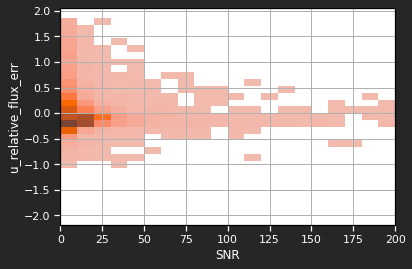

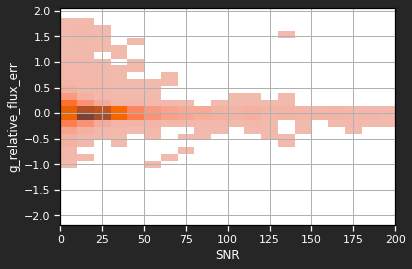

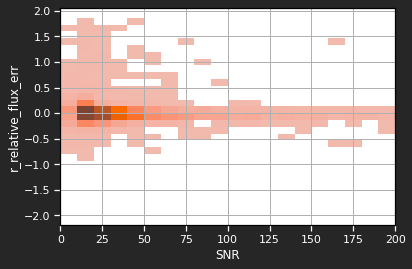

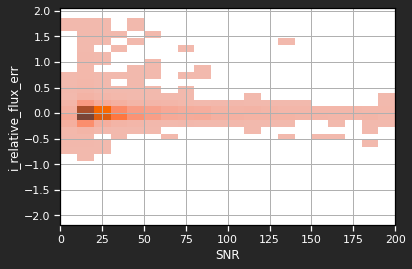

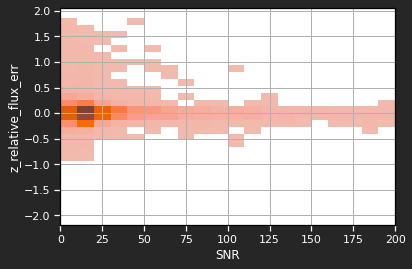

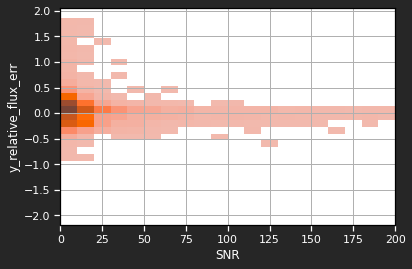

In [30]:
for band_num, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    snr = actual_photometry[band+"_flux"] / actual_photometry[band+"_fluxerrs"]
    #h = plt.hist2d(snr, madness_results[band+ "_relative_flux_err"], bins=30, cmin=2, range=[[0, 6], [-.4, .4]])
    x_bins = np.arange(0,1000,1000/100.0)
    y_bins = np.arange(-2, 2, 4/30.0)
    sns.histplot(x=snr, y=madness_results[band+ "_relative_flux_err"], bins=[x_bins, y_bins], kde=True, color="coral")
    plt.xlim(0,200)
    plt.xlabel("SNR")
    plt.show()

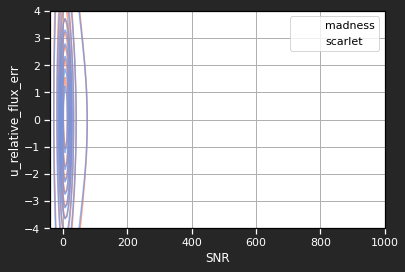

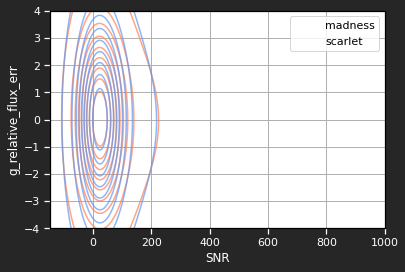

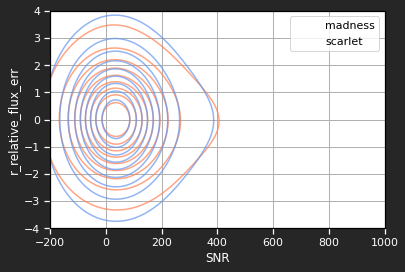

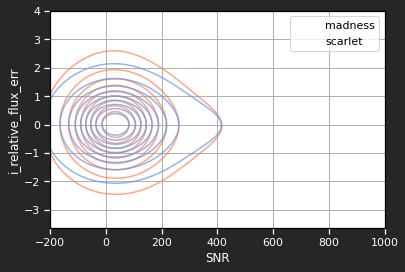

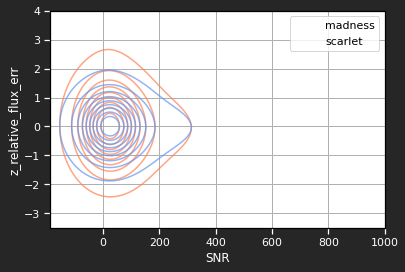

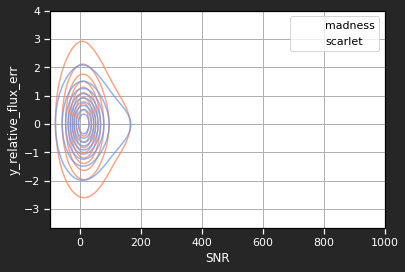

In [32]:
for band_num, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    snr = actual_photometry[band+"_flux"] / actual_photometry[band+"_fluxerrs"]
    #h = plt.hist2d(snr, madness_results[band+ "_relative_flux_err"], bins=30, cmin=2, range=[[0, 6], [-.4, .4]])
    x_bins = [-200, 1000]
    y_bins = [-4, 4]
    sns.kdeplot(x=snr, y=madness_results[band+ "_relative_flux_err"], clip=[x_bins, y_bins], fill=False, alpha=.7, label="madness",  color="coral")
    sns.kdeplot(x=snr, y=scarlet_results[band+ "_relative_flux_err"], clip=[x_bins, y_bins], fill=False, alpha=0.7, label="scarlet", color="cornflowerblue")
    plt.legend()
    plt.xlabel("SNR")
    plt.show()

# Compare with blendedness

/tmp/ipykernel_15404/3305847454.py:2: RuntimeWarning: invalid value encountered in log
  snr = np.log(actual_photometry[band+"_flux"] / actual_photometry[band+"_fluxerrs"])


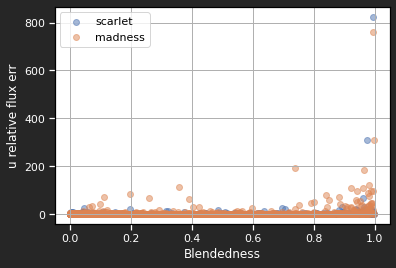

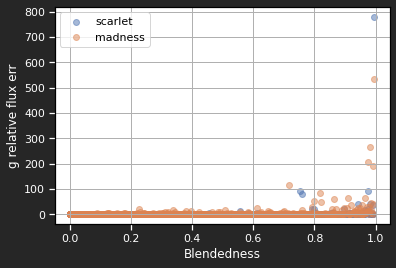

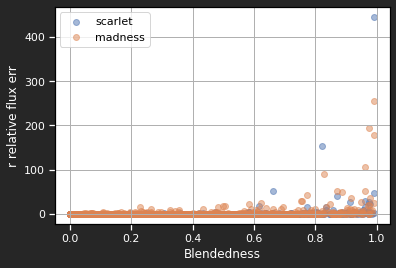

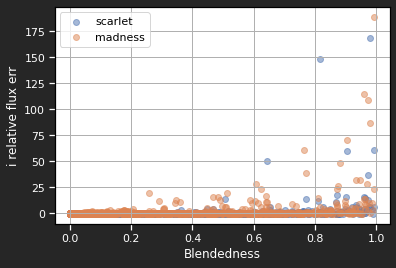

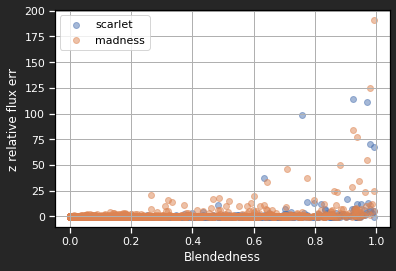

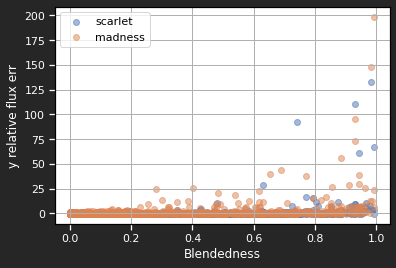

In [24]:
for band_num, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    snr = np.log(actual_photometry[band+"_flux"] / actual_photometry[band+"_fluxerrs"])
    #h = plt.hist2d(snr, madness_results[band+ "_relative_flux_err"], bins=30, cmin=2, range=[[0, 6], [-.4, .4]])
    plt.scatter(scarlet_results[band+"_blendedness"], scarlet_results[band+ "_relative_flux_err"], alpha=.5, label="scarlet")
    plt.scatter(madness_results[band+"_blendedness"], madness_results[band+ "_relative_flux_err"], alpha=.5, label="madness")
    plt.xlabel("Blendedness")
    plt.ylabel(band+" relative flux err")
    #sns.kdeplot(x=madness_results[band+"_blendedness"], y=madness_results[band+ "_relative_flux_err"], clip=[x_bins, y_bins], fill=False, alpha=.7)
    #sns.kdeplot(x=snr, y=scarlet_results[band+ "_relative_flux_err"], clip=[x_bins, y_bins], fill=False, alpha=0.7
    plt.legend()
    plt.show()

In [25]:
# Validate SNR vs mag 

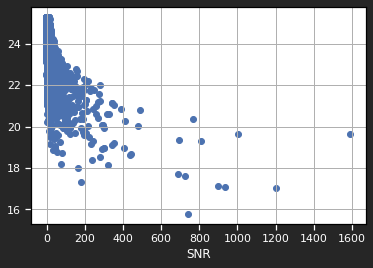

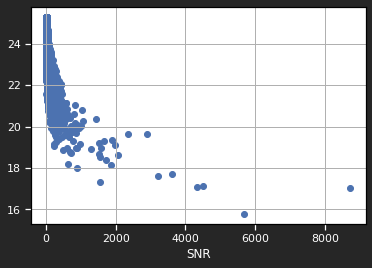

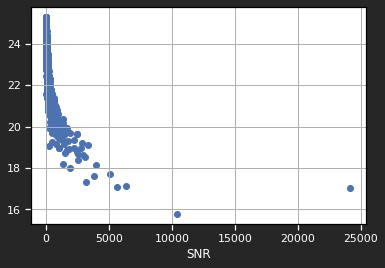

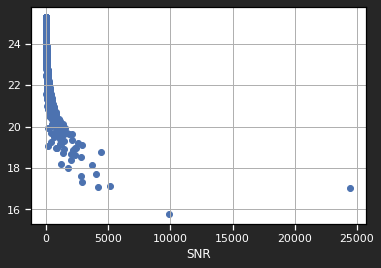

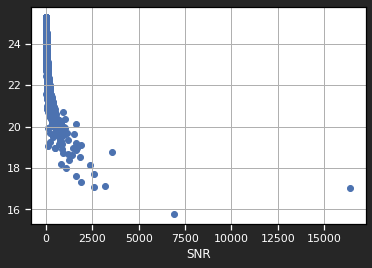

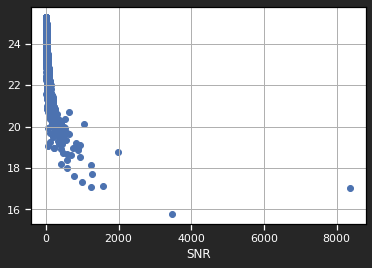

In [26]:
for band_num, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    snr = actual_photometry[band+"_flux"] / actual_photometry[band+"_fluxerrs"]
    #h = plt.hist2d(snr, madness_results[band+ "_relative_flux_err"], bins=30, cmin=2, range=[[0, 6], [-.4, .4]])
    x_bins = [-200, 1000]
    y_bins = [-2, 2]
    plt.scatter(x=snr, y=madness_results["ref_mag"])
    #sns.kdeplot(x=snr, y=scarlet_results[band+ "_relative_flux_err"], clip=[x_bins, y_bins], fill=False, alpha=0.7, label="scarlet")
    plt.xlabel("SNR")
    plt.show()

Plot for u band


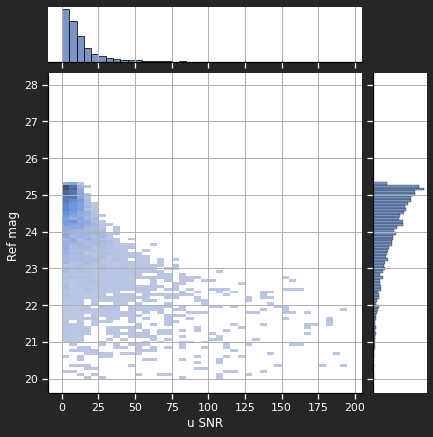

Plot for g band


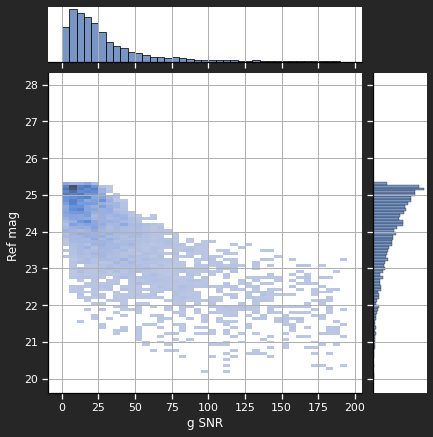

Plot for r band


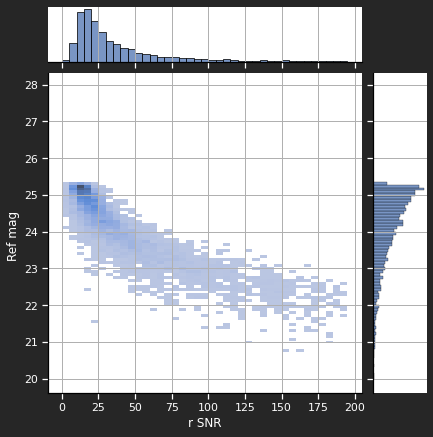

Plot for i band


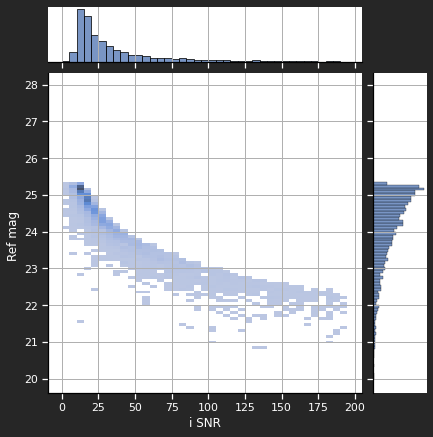

Plot for z band


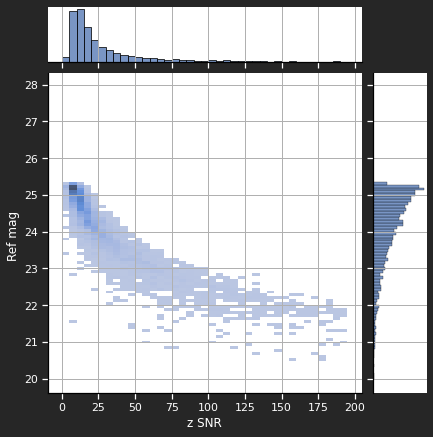

Plot for y band


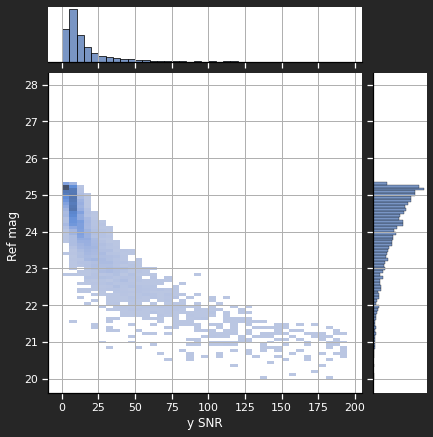

In [27]:
for band_num, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    print(f"Plot for {band} band")
    snr = actual_photometry[band+"_flux"].value / actual_photometry[band+"_fluxerrs"].value
    #h = plt.hist2d(snr, madness_results[band+ "_relative_flux_err"], bins=30, cmin=2, range=[[0, 6], [-.4, .4]])
    x_bins = np.arange(0,200,5.0)
    y_bins = np.arange(20, 28, 8/100.0)
    #sns.histplot(x=snr, y=madness_results["ref_mag"], bins=[x_bins, y_bins], kde=False, cbar=True)
    g = sns.JointGrid()
    sns.histplot(x=snr, y=madness_results["ref_mag"], bins=[x_bins, y_bins], kde=False, ax=g.ax_joint)
    g.ax_joint.set_xlabel(band + " SNR")
    g.ax_joint.set_ylabel("Ref mag ")
    sns.histplot(x=snr, ax=g.ax_marg_x, bins=x_bins, kde_kws={'clip': (0,500)})
    sns.histplot(y=madness_results["ref_mag"], ax=g.ax_marg_y, bins=y_bins)
    #ax.set(xlabel='SNR', ylabel='Ref Mag '+band)
    
    plt.show()

In [28]:
np.sum(madness_results['ref_mag']!=madness_results['mag_auto'])

KeyError: 'mag_auto'